## Hierarchical modularity in multiple cortical areas

We will collect neurons from several cortical areas to get the *functional connectivity* and perform the *dynamical analysis*.     
This will address three relevant points:
- Does the dynamic analysis hold at **higher temporal resolution**?
- Do **all areas of cortex** show attractor dynamics?
- Are population events only a **side-effect of behavior** (locomotion, whisker pad, pupil)?

To do all this, we analyse the [data](https://janelia.figshare.com/articles/dataset/Eight-probe_Neuropixels_recordings_during_spontaneous_behaviors/7739750/4) by [Stringer et al. 2019](science.org/doi/10.1126/science.aav7893).   
Eight-probe Neuropixels recordings in three mice during spontaneous activity.

In [1]:
from platform import python_version
print(python_version())

from builtins import exec
exec(open("./imports_functions.py").read())

%matplotlib inline

3.10.4


In [ ]:
if not os.path.exists("stringer/7739750.zip"):
    print("Downloading neuropixel data ...")
    resp = wget.download("https://janelia.figshare.com/ndownloader/articles/7739750/versions/4", "stringer/7739750.zip")
    print("... Done: "+resp)

# unzip downloaded folder
# unzip spks.zip and faces.zip

This analysis is based on the file `ephysLoad.m`.

Each "spks" is a structure of length 8, where each entry is a different probe (these probes were recorded simultaneously). It contains the spike times (in seconds, e.g. 4048.44929626 sec = 4048449.29626 ms (?kHz sampling)), the cluster identity of each spike (its cell), and the height of each cluster on the probe.

The location of each site on the probe in microns in the Allen CCF framework is given in "ccfCoords". The brain area for each site is in "borders" as a function of the height of the site. 

In [17]:
if os.path.exists("stringer/7739750/area_spiketrains.npy"):
    area_spiketrains = np.load("stringer/7739750/area_spiketrains.npy", allow_pickle=True)
    print("... loaded populations")
else:
    print("... collecting populations")
    
    probeLoc = sio.loadmat('stringer/7739750/probeLocations.mat')
    probeBorders = sio.loadmat('stringer/7739750/probeBorders.mat', squeeze_me=True)

    mouse_names = ['Krebs','Waksman','Robbins']
    # mouse_names = ['Krebs']
    cortical_areas = ['FrCtx','FrMoCtx','SomMoCtx','SSCtx','V1','V2','RSP']

    # first count the cells you want to take with this structure
    # then think on how you want to store the spikes... compatible with the dynamical_analysis
    area_spiketrains = {
        'Krebs' : {'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[]},
        'Waksman' : {'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[]},
        'Robbins' : {'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[]}
    }

    # start of spontaneous activity in each mouse (in seconds)
    tstart = [3811, 3633, 3323] # what's in there before?

    for imouse in range(len(mouse_names)):
        print(mouse_names[imouse])

        spks = sio.loadmat('stringer/7739750/spks/spks%s_Feb18.mat'%mouse_names[imouse], squeeze_me=True)

        # probe k
        # k = 7
        for k in range(8):
            print("probe",k)

            # spike times (in seconds)
            st = spks['spks'][k][0]
            # clusters
            clu = spks['spks'][k][1]
            print("clusters (cells) of the spikes",len(np.unique(clu)))
            # cluster heights (in microns)
            # (see siteCoords to convert to site location)
            Wh = spks['spks'][k][2]

            # where is the probe in the brain (consolidated labels)
            # borders are in microns
            # use Wh to determine which clusters are in which brain region
            borders = probeBorders['probeBorders'][imouse]['borders'][k]
            for j in range(len(borders)):
                population = [] # one population per border, there can be several borders
                b = borders[j]
                if b[2] not in cortical_areas:
                    continue
                print('upper border %d um, lower border %d um, area %s'%(b[0],b[1],b[2]))
                wneurons = np.logical_and(Wh>=b[1], Wh<b[0])
                nn = wneurons.sum()
                print('%d neurons in %s'%(nn,b[-1]))
                # we should not include population smaller than those in MICrONS
                if nn<10:
                    print('population too small. Rejected.')
                    continue

                cortical_neurons = np.nonzero(wneurons)[0]
                for cn in cortical_neurons:
                    cn_idxs = [i for i in range(len(clu)) if clu[i]==cn]
                    # print(cn_idxs)
                    population.append( sorted(st[cn_idxs]) )
                    
                area_spiketrains[ mouse_names[imouse] ][ b[2] ].append( population )
            print()

    # save to file
    np.save("stringer/7739750/area_spiketrains.npy", area_spiketrains)


... collecting populations
Krebs
probe 0
clusters (cells) of the spikes 127
upper border 4000 um, lower border 1100 um, area FrMoCtx
5 neurons in FrMoCtx
population too small. Rejected.

probe 1
clusters (cells) of the spikes 249
upper border 4000 um, lower border 1800 um, area FrMoCtx
73 neurons in FrMoCtx

probe 2
clusters (cells) of the spikes 149
upper border 4000 um, lower border 2600 um, area V1
61 neurons in V1

probe 3
clusters (cells) of the spikes 304
upper border 4000 um, lower border 2400 um, area V1
141 neurons in V1

probe 4
clusters (cells) of the spikes 126
upper border 4000 um, lower border 1800 um, area SomMoCtx
65 neurons in SomMoCtx

probe 5
clusters (cells) of the spikes 137
upper border 4000 um, lower border 2100 um, area SomMoCtx
26 neurons in SomMoCtx

probe 6
clusters (cells) of the spikes 205
upper border 4000 um, lower border 2350 um, area V1
68 neurons in V1

probe 7
clusters (cells) of the spikes 165
upper border 4000 um, lower border 2600 um, area V1
64 ne

- Krebs
    - probe 0      
      upper border 4000 um, lower border 1100 um, area FrMoCtx      
      5 neurons in FrMoCtx
      population too small. Rejected.
    - probe 1      
      upper border 4000 um, lower border 1800 um, area FrMoCtx      
      73 neurons in FrMoCtx
    - probe 2      
      upper border 4000 um, lower border 2600 um, area V1      
      61 neurons in V1
    - probe 3      
        upper border 4000 um, lower border 2400 um, area V1      
        141 neurons in V1
    - probe 4      
        upper border 4000 um, lower border 1800 um, area SomMoCtx      
        65 neurons in SomMoCtx
    - probe 5      
        upper border 4000 um, lower border 2100 um, area SomMoCtx      
        26 neurons in SomMoCt
    - probe 6      
        upper border 4000 um, lower border 2350 um, area V1      
        68 neurons in V1
    - probe 7      
        upper border 4000 um, lower border 2600 um, area V1      
        64 neurons in V1

- Waksman
    - probe 0      
        upper border 4000 um, lower border 1700 um, area FrMoCtx      
        446 neurons in FrMoCtx      
        upper border 1200 um, lower border 0 um, area FrMoCtx      
        201 neurons in FrMoCtx

    - probe 1      
        upper border 4000 um, lower border 2150 um, area FrCtx      
        31 neurons in FrCtx

    - probe 2            
        upper border 4000 um, lower border 2700 um, area V1      
        155 neurons in V1

    - probe 3      
        upper border 4000 um, lower border 2250 um, area RSP      
        112 neurons in RSP

    - probe 4      
        upper border 4000 um, lower border 2000 um, area SomMoCtx      
        220 neurons in SomMoCtx

    - probe 5      
        upper border 4000 um, lower border 2600 um, area SSCtx      
        50 neurons in SSCtx

    - probe 6      
        upper border 4000 um, lower border 2650 um, area V2      
        124 neurons in V2

    - probe 7      
        upper border 4000 um, lower border 2850 um, area V1      
        96 neurons in V1

- Robbins
    - probe 0      
        upper border 4000 um, lower border 3400 um, area FrMoCtx      
        16 neurons in FrMoCtx

    - probe 1      
        upper border 4000 um, lower border 3100 um, area FrMoCtx      
        70 neurons in FrMoCtx

    - probe 3      
        upper border 4000 um, lower border 3550 um, area RSP      
        10 neurons in RSP

    - probe 4      
        upper border 4000 um, lower border 3500 um, area SomMoCtx      
        10 neurons in SomMoCtx

In [2]:
area_spiketrains = np.load("stringer/7739750/area_spiketrains.npy", allow_pickle=True).item()

In [ ]:
frame_duration = 0.0674 # sec, 14.8313 frames per second

Krebs
FrMoCtx
73


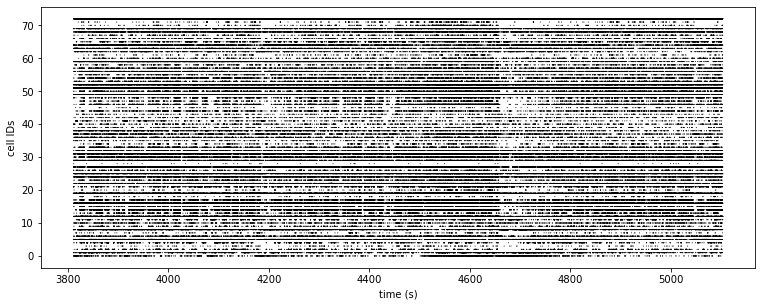

ZeroDivisionError: division by zero

In [3]:
for mousename,areas in area_spiketrains.items():
    print(mousename)
    for area,probe_populations in areas.items():
        if len(probe_populations)>0:
            print(area)
            for ipop,spiketrains in enumerate(probe_populations):
                print(len(spiketrains)) # this corresponds to the list required by dynamical analysis
                
                fig = plt.figure(figsize=[12.8,4.8])
                for row,train in enumerate(spiketrains):
                    plt.scatter( train, [row]*len(train), marker='o', edgecolors='none', s=1, c='k' )
                plt.ylabel("cell IDs")
                plt.xlabel("time (s)")
                # plt.show()
                fig.savefig('stringer/7739750/%s/%s_%s_rasterplot.png'%(mousename,area,ipop), transparent=False, dpi=800)
                plt.tight_layout()
                plt.close()

                ophys_cell_ids = list(range(len(spiketrains)))
                ophys_cell_indexes = range(len(ophys_cell_ids))
                n_frames = len(calcium_trace[ophys_cell_ids[0]]['spike'])
                print(n_frames)
                start_time = 0 # 200 frames of blank screen are already removed from the data
                stop_time = (n_frames)*frame_duration
                time = np.arange(start_time,stop_time,frame_duration)

                global_events = [[] for i in range(5)] # by scan
                global_events_sec = []
                global_events_duration = []
                global_cluster_number = []
                global_cluster_selfsimilarity = []
                global_tot_clusters = [[] for i in range(5)] # by scan
                global_clustered_spectrums = []

                core_reproducibility_perc = 60 # threshold for detecting cores
    
                %run "dynamical_analysis.ipynb"

                global_events_sec.append(events_sec)
                global_events_duration.extend(events_durations_f)
                global_cluster_number.append(nclusters)
                global_cluster_selfsimilarity.extend(reproducibility_list)

                0/0
    print()

In [ ]:
# # processed faces, to correlate behavior
# # The behavioral file is the processed version of a mouse face movie (time x pixels x pixels). 
# faces = io.loadmat('stringer/7739750/faces/%s_face_proc.mat'%mouse_names[imouse], squeeze_me=True)
# motSVD = faces['motionSVD']
# video_timestamps = faces['times']